# Residency-8: Project-1 | ComputerVisionWithCNN_R8

Project 1:

 

The case study is from a dataset from Kaggle. 

Link to the Kaggle project site:

https://www.kaggle.com/c/plant-seedlings-classification (Links to an external site.)Links to an external site.

 

 

The dataset has to be downloaded from the above Kaggle web site.

 

 

Can you differentiate a weed from a crop seedling?

The ability to do so effectively can mean better crop yields and better stewardship of the environment.

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages.

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib as pth
import ast
import re
import tarfile
import imageio
from ast import literal_eval
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from collections import Counter, defaultdict
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
np.random.seed(42)
tf.set_random_seed(42)
tf.__version__
tf.keras.__version__
tf.reset_default_graph()
py.init_notebook_mode(connected=True)
#Unfreeze (make trainable) these VGG16 layers
LAYER = ["block5_conv1", "block5_conv2", "block4_conv3" ]

'1.14.0'

'2.2.4-tf'

In [12]:
# Root directory for the project
#            ***VERY URGENT NOTE***
# 1. first, PLEASE CREATE THE "data" FOLDER AT
#    THE SAME LEVEL, WHERE THE IPYNB FILE IS.
# 2. WHILE YOU PASTE THIS CODE TO IPYNB-environment,
#    PLEASE USE THE BELOW COMMENTED LINE, IN THAT CASE
PRJ_ROOT_DIR = r"{}\\".format(pth.Path.cwd())
# IF YOU ARE RUNNING THIS CODE, in say, PYCHARM-ENV
# USE THE LINE BELOW FOR "PRJ_ROOT_DIR"
#PRJ_ROOT_DIR = r"{}\..\\".format(pth.Path.cwd())
# Data-Set path (assuming, data set will be @ the "data" folder
# under a project root.
DATA_SET_PATH = r"{}\\data\\".format(PRJ_ROOT_DIR)
DATA_SET_XLS_PATH = r"{}\data\*.xlsx".format(PRJ_ROOT_DIR)
# Below data is provided as csv file, with col-names already there.
DATA_SET_CSV_PATH = r"{}\data\labels.csv".format(PRJ_ROOT_DIR)
TRAIN_CSV_PATH = DATA_SET_PATH + 'train.csv'
TEST_CSV_PATH = DATA_SET_PATH + 'test.csv'
BATCHSIZE = 64

In [13]:
def cleanup_column_names(df):
    """
    This routine "cleans" up the column names, in the sense that the non alphanumeric, non-word characters are
    replaced with underscore-joined names instead

    :param df:
    """
    new_col_names = []
    for col_name in df.columns:
        # Remove all non-word characters (everything except numbers and letters)
        col_name = re.sub(r"[^\w\s]", '', col_name)
        # Replace all runs of whitespace with a single dash
        col_name = re.sub(r"\s+", '_', col_name)
        new_col_names.append(col_name)
    df.rename(columns={i: j for i, j in zip(df.columns, new_col_names)}, inplace=True)


def read_data_set(data_path, is_text=False, usr_col_list=None):
    """
    Read the csv or excel file at a given path, into a dataframe & return the same
    :param usr_col_list:
    :param is_text:
    :param data_path:
    :return:
    """
    if data_path == DATA_SET_XLS_PATH:
        df = pd.read_excel(data_path, encoding="ISO-8859-1")
    elif is_text:
        df = pd.read_csv(DATA_SET_CSV_PATH, names=usr_col_list)
    else:
        df = pd.read_csv(data_path, encoding="ISO-8859-1")
    cleanup_column_names(df)
    col_name_full = list(df.columns)
    return df.loc[:, col_name_full]



def split_train_test(image_df, test_size=0.2, random_state=42):
    """
    """
    train_df, test_df = train_test_split(image_df, test_size=test_size, random_state=random_state)
    train_df.reset_index(inplace=True, drop=True)
    test_df.reset_index(inplace=True, drop=True)
    print("Final Train-Dataset-shape:{}".format(train_df.shape))
    print("Final Direct Test-Dataset-shape:{}".format(test_df.shape))
    train_df.to_csv(TRAIN_CSV_PATH)
    test_df.to_csv(TEST_CSV_PATH)


def read_train_test_data(train_path, test_path):
    """
    Read the train/test dataframes from saved csv files
    :param path:
    :return:test_df/train_df
    """
    train_df = pd.read_csv(train_path, encoding="ISO-8859-1")
    test_df = pd.read_csv(test_path, encoding="ISO-8859-1")
    return train_df, test_df


def batch_generator(df, batchsize=32, train_mode=True):
    """
    Build the batch generator
    :param df:
    :param batchsize:
    :param train_mode:
    :yields:batch_images, batch_labels
    """    
    img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    horizontal_flip=True,
                                                                    zoom_range=[0.3, 5.0],
                                                                    shear_range=0.2)
    lb1 = LabelBinarizer()
    df_lb = pd.DataFrame(lb1.fit_transform(df['species']),columns=lb.classes_)
    while True:
        # Create a batch-indexer to populate the image & correspnding labels
        # batch-wise
        batch_nums = np.random.randint(0, df.shape[0], size=batchsize)
        # Create placeholders for the returned batch_images & batch_labels
        batch_images = np.zeros((batchsize, img_size, img_size, img_depth))
        batch_labels = np.zeros((batchsize, len(class_names)))
        for i in range(batchsize):
            #get an image & label one at a time from the dataframe
            image = tf.keras.preprocessing.image.load_img('./data/' + df.loc[batch_nums[i]]['species']+ '/'+ df.loc[batch_nums[i]]['file'],
                                                          target_size=(img_size, img_size))
            # Convert to numpy array
            image = tf.keras.preprocessing.image.img_to_array(image)
            if train_mode:
                # Apply transform
                image = img_generator.random_transform(image)
            label = df_lb[lb.classes_].values[batch_nums[i]]
            batch_images[i] = image
            batch_labels[i] = label
        yield batch_images, batch_labels            
            

def pred_func(df, batchsize=32, train_mode=True):
    """
    Build the batch generator
    :param df:
    :param batchsize:
    :param train_mode:
    :yields:batch_images, batch_labels
    """    
    lb1 = LabelBinarizer()
    df_lb = pd.DataFrame(lb1.fit_transform(df['species']),columns=lb.classes_)
    batch_nums = np.random.randint(0, df.shape[0], size=batchsize)
    # Create placeholders for the returned batch_images & batch_labels
    batch_images = np.zeros((batchsize, img_size, img_size, img_depth))
    batch_labels = np.zeros((batchsize, len(class_names)))
    for i in range(batchsize):
        #get an image & label one at a time from the dataframe
        image = tf.keras.preprocessing.image.load_img('./data/' + df.loc[batch_nums[i]]['species']+ '/'+ df.loc[batch_nums[i]]['file'],
                                                      target_size=(img_size, img_size))
        # Convert to numpy array
        image = tf.keras.preprocessing.image.img_to_array(image)
        label = df_lb[lb.classes_].values[batch_nums[i]]
        batch_images[i] = image/255
        batch_labels[i] = label
    return batch_images, tf.keras.utils.to_categorical(batch_labels)   

        
def pred_func(df, batchsize=32):
    lb1 = LabelBinarizer()
    df_lb = pd.DataFrame(lb1.fit_transform(df['species']),columns=lb.classes_)
    batch_nums = np.random.randint(0, df.shape[0], size=batchsize)
    # Create placeholders for the returned batch_images & batch_labels
    batch_images = np.zeros((batchsize, img_size, img_size, img_depth))
    batch_labels = np.zeros((batchsize, len(class_names)))
    for i in range(batchsize):
        #get an image & label one at a time from the dataframe
        image = tf.keras.preprocessing.image.load_img('./data/' + df.loc[batch_nums[i]]['species']+ '/'+ df.loc[batch_nums[i]]['file'],
                                                      target_size=(img_size, img_size))
        # Convert to numpy array
        image = tf.keras.preprocessing.image.img_to_array(image)
        label = df_lb[lb.classes_].values[batch_nums[i]]
        batch_images[i] = image#/255
        batch_labels[i] = label
    return batch_images, batch_labels


def layer_output(model, layer_name=None):
    """Output tensor of a specific layer in a model.
    """
    conv_index = -1

    for i in range(len(model.layers) - 1, -1, -1):
        layer = model.layers[i]
        if layer_name in layer.name:
            conv_index = i
            break

    if conv_index < 0:
        print('Error: could not find the interested layer.')

    return model.layers[conv_index].output

### Read the images and generate the train and test dataset (10 points)

In [14]:
image_df = read_data_set(DATA_SET_CSV_PATH)

In [15]:
image_df.head()

,file,species
0,0050f38b3.png,Black-grass
1,0183fdf68.png,Black-grass
2,0260cffa8.png,Black-grass
3,05eedce4d.png,Black-grass
4,075d004bc.png,Black-grass


In [16]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 500)

In [17]:
image_df.shape

(4750, 2)

### 2) Divide the data set into Train and validation data sets

In [18]:
split_train_test(image_df)

Final Train-Dataset-shape:(3800, 2)
Final Direct Test-Dataset-shape:(950, 2)


In [19]:
train_df, test_df = read_train_test_data(TRAIN_CSV_PATH,TEST_CSV_PATH)

In [20]:
train_df.shape
test_df.shape

(3800, 3)

(950, 3)

In [21]:
#Get the class names
lb = LabelBinarizer()
df = pd.DataFrame(lb.fit_transform(train_df['species']),columns=lb.classes_)
class_names = list(lb.classes_)
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common_Chickweed', 'Common_wheat', 'Fat_Hen', 'Loose_Silky-bent', 'Maize', 'Scentless_Mayweed', 'Shepherds_Purse', 'Small-flowered_Cranesbill', 'Sugar_beet']


### 3) Initialize & build the model (20 points)

### 4) Optimize the model (16 points)

In [22]:
# Define some parameters
img_size =224
img_depth = 3

In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('seedling_weed_model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto') 

[INFO] summary for base model...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)  

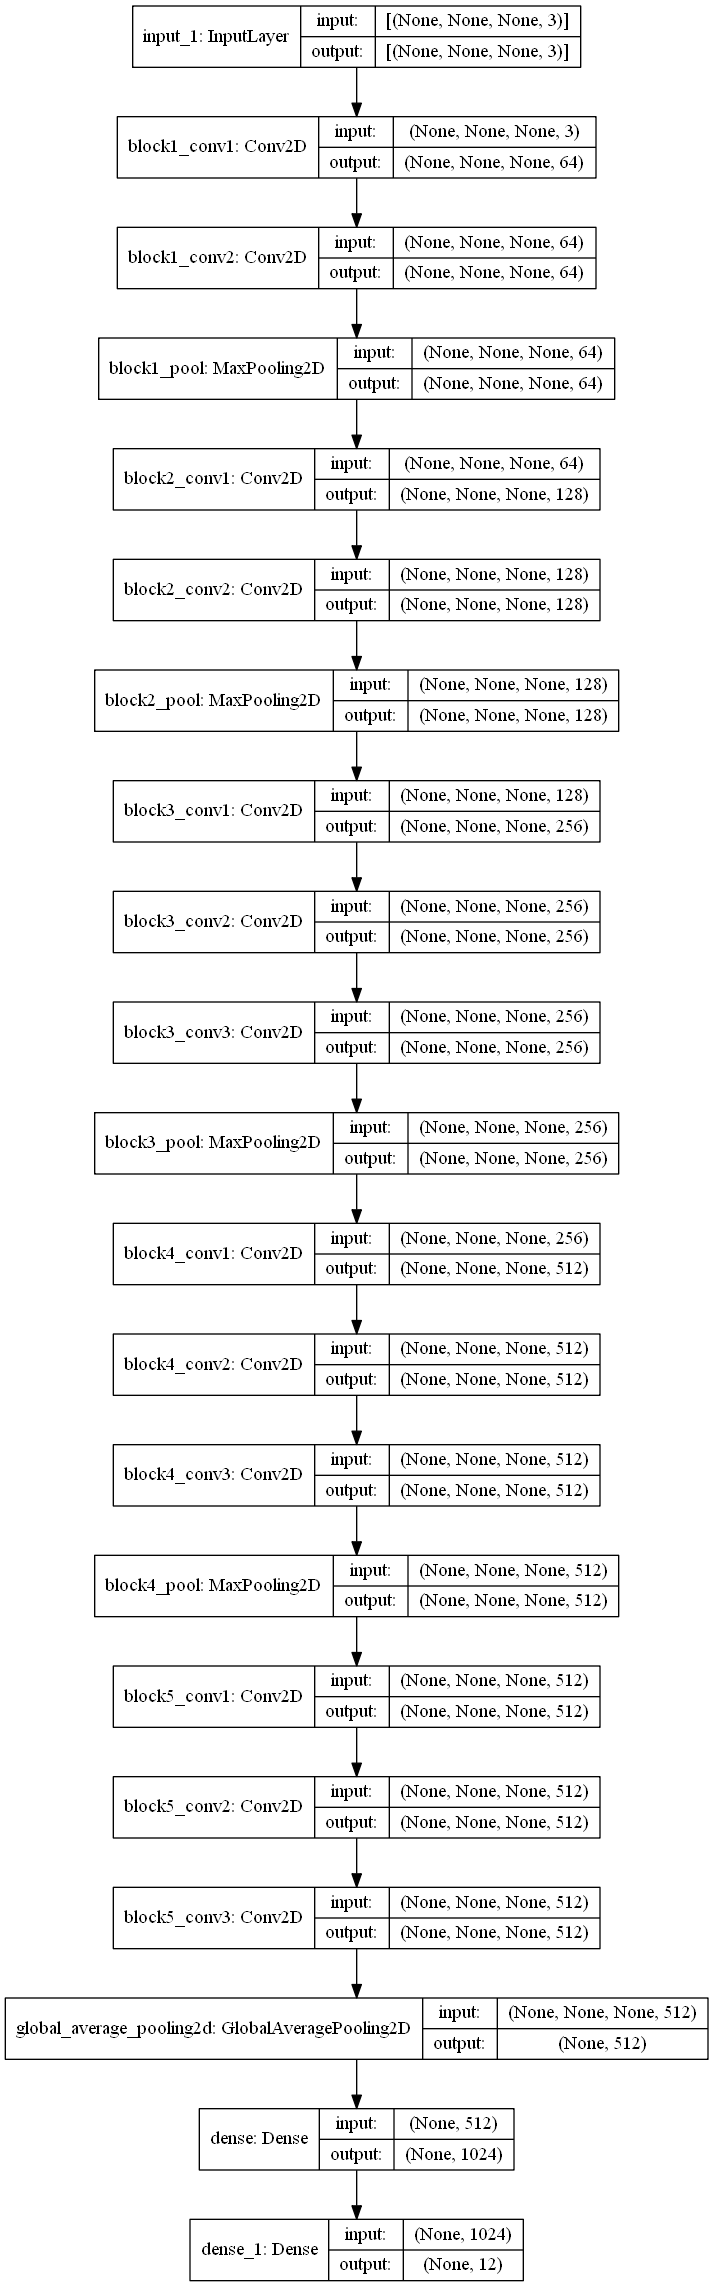

In [428]:
# load VGG16, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network
baseModel = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)

# show a summary of the base model
print("[INFO] summary for base model...")
print(baseModel.summary())

gap_input = layer_output(baseModel, 'block5_conv3')

# construct the head of the model that will be placed on top of the
# the base model
headModel = gap_input
headModel = tf.keras.layers.GlobalAveragePooling2D()(headModel)
headModel = tf.keras.layers.Dense(1024, activation='relu')(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(len(class_names), activation='softmax')(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    if layer.name in LAYER:
        layer.trainable = True
    else:
        layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# summarize layers
print(model.summary())
# plot graph
tf.keras.utils.plot_model(model, to_file='shared_input_layer.png', show_shapes=True, show_layer_names=True)

In [429]:
# Create a test and train generator
batchsize = 32
train_generator = batch_generator(train_df, batchsize=batchsize)
test_generator  = batch_generator(test_df, batchsize=batchsize, train_mode=False)

In [430]:
model.fit_generator(train_generator, 
                    epochs=20, 
                    steps_per_epoch=train_df.shape[0]//batchsize, 
                    validation_data=test_generator, 
                    validation_steps=test_df.shape[0]//batchsize,
                    callbacks=[checkpoint])

Epoch 1/20
117/118 [============================>.] - ETA: 0s - loss: 2.2722 - acc: 0.2238
Epoch 00001: val_acc improved from -inf to 0.33297, saving model to seedling_weed_model-001-0.224311-0.332974.h5
118/118 [==============================] - 86s 731ms/step - loss: 2.2707 - acc: 0.2243 - val_loss: 1.9744 - val_acc: 0.3330
Epoch 2/20
117/118 [============================>.] - ETA: 0s - loss: 1.3784 - acc: 0.5155
Epoch 00002: val_acc improved from 0.33297 to 0.61961, saving model to seedling_weed_model-002-0.516949-0.619612.h5
118/118 [==============================] - 96s 815ms/step - loss: 1.3740 - acc: 0.5169 - val_loss: 1.0806 - val_acc: 0.6196
Epoch 3/20
117/118 [============================>.] - ETA: 0s - loss: 0.9600 - acc: 0.6675
Epoch 00003: val_acc improved from 0.61961 to 0.71336, saving model to seedling_weed_model-003-0.668697-0.713362.h5
118/118 [==============================] - 98s 827ms/step - loss: 0.9566 - acc: 0.6687 - val_loss: 0.8971 - val_acc: 0.7134
Epoch 4/20

In [431]:
model.save('seedling_weed_model.h5')

### 5) Predict the accuracy for both train and validation data (14 points)

In [24]:
#working with the best model out of the above epochs
model = tf.keras.models.load_model('seedling_weed_model-019-0.871292-0.904095.h5')

#### Train accuracy

In [25]:
X, y_train = pred_func(train_df, train_df.shape[0])
out_train = model.predict(X)

In [26]:
ypred = []
for val in out_train:
    ypred.append(np.argmax(val))

In [27]:
ytrain = []
for val in y_train:
    ytrain.append(np.argmax(val))

In [28]:
cm = metrics.confusion_matrix(ytrain,ypred)
print(cm)

[[158   0   0   0   8   2  41   0   0   0   0   0]
 [  0 310   4   0   0   2   0   0   0   0   2   0]
 [  2   0 215   0   0  13   0   0   2   3   1   0]
 [  0   0   0 415   0  21   0   0  16   0   3   0]
 [  9   0   0   0 158   6   0   0   1   0   0   0]
 [  0   0   0   0   5 397   0   0   2   0   0   2]
 [ 51   0   0   0   2   0 439   0   0   0   0   0]
 [  1   0   0   0   0   0   0 160   6   0   0   0]
 [  1   0   5   2   0   4   0   0 431  10   5   0]
 [  0   0   8  16   0   3   0   0  19 138  18   0]
 [  1   0   3   0   0   1   0   0   3   0 374   0]
 [  3   0   0   2   1  37   0   3   3   0   0 252]]


In [29]:
cr=metrics.classification_report(ytrain,ypred)
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       209
           1       1.00      0.97      0.99       318
           2       0.91      0.91      0.91       236
           3       0.95      0.91      0.93       455
           4       0.91      0.91      0.91       174
           5       0.82      0.98      0.89       406
           6       0.91      0.89      0.90       492
           7       0.98      0.96      0.97       167
           8       0.89      0.94      0.92       458
           9       0.91      0.68      0.78       202
          10       0.93      0.98      0.95       382
          11       0.99      0.84      0.91       301

    accuracy                           0.91      3800
   macro avg       0.91      0.89      0.90      3800
weighted avg       0.91      0.91      0.91      3800



#### Validation accuracy

In [30]:
X, y_test = pred_func(test_df, test_df.shape[0])
out = model.predict(X)

In [31]:
ypred = []
for val in out:
    ypred.append(np.argmax(val))

In [32]:
ytest = []
for val in y_test:
    ytest.append(np.argmax(val))

In [33]:
cm = metrics.confusion_matrix(ytest,ypred)
print(cm)

[[ 44   0   0   0   0   0  14   0   0   0   0   0]
 [  0  60   0   0   0   2   0   0   0   0   0   0]
 [  0   0  62   0   0   1   0   0   0   0   2   0]
 [  0   0   0 120   0   1   0   1  12   0   0   0]
 [  0   0   0   0  34   5   0   0   1   0   0   0]
 [  0   0   0   0   4  82   0   0   0   0   0   0]
 [  8   0   0   0   0   0 141   0   0   0   0   0]
 [  1   0   0   0   0   1   0  45   0   0   0   0]
 [  1   0   2   1   0   4   0   0  88   3   0   0]
 [  0   0   1   6   0   2   0   0   2  23   5   0]
 [  0   0   3   0   0   1   0   0   0   2  90   0]
 [  1   0   0   0   0   5   0   3   0   0   0  66]]


In [34]:
cr=metrics.classification_report(ytest,ypred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        58
           1       1.00      0.97      0.98        62
           2       0.91      0.95      0.93        65
           3       0.94      0.90      0.92       134
           4       0.89      0.85      0.87        40
           5       0.79      0.95      0.86        86
           6       0.91      0.95      0.93       149
           7       0.92      0.96      0.94        47
           8       0.85      0.89      0.87        99
           9       0.82      0.59      0.69        39
          10       0.93      0.94      0.93        96
          11       1.00      0.88      0.94        75

    accuracy                           0.90       950
   macro avg       0.90      0.88      0.89       950
weighted avg       0.90      0.90      0.90       950

